## Autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy import signal
from scipy.linalg import hankel, svd, eig
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
import ipywidgets as widgets
from IPython.display import display
from signalepy import plot, settings, utils, analysis
import json
import os
import warnings

## Parameters

### Accceleration data

**File name and location**

In [3]:
file_name = 'espectros_cscr_2002/CSCR02 FED S1-Z2-u1.0.txt'
file_location = utils.get_data_files_location(file_name)

json_file = 'espectros_cscr_2002/CSCR02_defaults.json'
json_location = utils.get_data_files_location(json_file)


In [ ]:
file_location

WindowsPath('C:/Users/ingah/estructuraPy/signalepy/src/signalepy/data/espectros_cscr_2002/CSCR02 FED S1-Z2-u1.0.txt')

In [ ]:
json_location

WindowsPath('C:/Users/ingah/estructuraPy/signalepy/src/signalepy/data/espectros_cscr_2002/CSCR02_defaults.json')


**Import acceleration data**

In [6]:
df_f = utils.import_cscr_fed(file_location, json_location)

In [7]:
total_time = 50.
sampling_rate = 200

frequency_funcs = df_f['Frequency'].tolist()
amplitude_funcs = df_f['FED'].tolist()

label ='Z'

noise_amplitude = 0

In [8]:
df = analysis.generate_vibration_signal_dataframe(total_time, sampling_rate, frequency_funcs, amplitude_funcs, noise_amplitude, label)

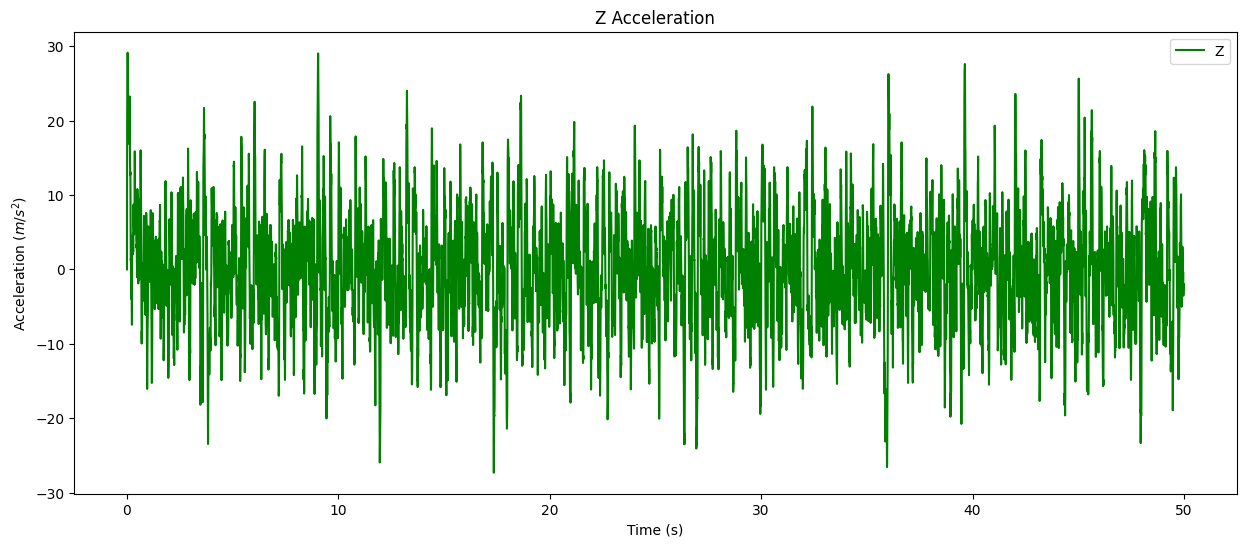

In [9]:
plot.acceleration(df, label, color='green')

## FFT analysis

In [10]:
label_corrected = f'{label}_corrected'
df = analysis.baseline_correction(df, label, label_corrected)

In [11]:
df_fft = analysis.calculate_fft(df, label_corrected)

## Denoising

In [12]:
label_filtered= f'{label} filtered'
threshold_percentage = 10
analysis.fft_filter(df=df, threshold_percentage=threshold_percentage, label=label_corrected, label_filtered=label_filtered)

,Time,Z Acceleration,Z_corrected Acceleration,Z filtered Acceleration
0,0.000,0.000000,-0.344114,0.684667
1,0.005,13.210139,12.866085,7.781191
2,0.010,21.099333,20.755340,10.778550
3,0.015,0.082224,-0.261708,11.101286
4,0.020,0.082224,-0.261648,11.642670
...,...,...,...,...
9995,49.975,-3.526601,-3.265033,-13.466990
9996,49.980,-3.246518,-2.984889,-13.024962
9997,49.985,-2.394169,-2.132479,-11.905612
9998,49.990,-2.625210,-2.363459,-10.654753


In [13]:
magnitude_type = 'normalized'
magnitude_factor = max(df_f['FED'])
df_fft = analysis.calculate_fft(df, label_filtered, magnitude_type, magnitude_factor)

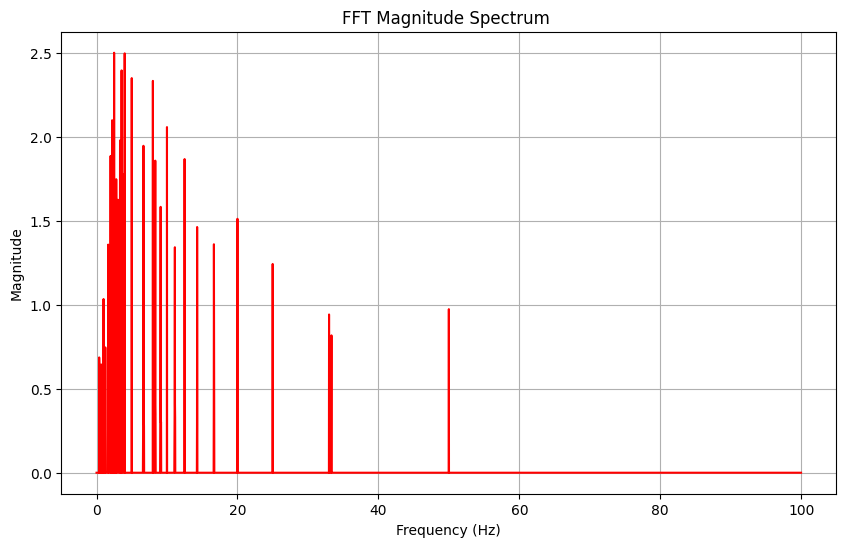

In [14]:
plot.fft_results(df_fft, label_filtered)

In [17]:
wavelet ='morl'
min_scale = 2
max_scale = 32

In [18]:
spectrum, frequencies = analysis.cwt(df, label, wavelet, min_scale, max_scale, magnitude_type, magnitude_factor)

In [19]:
gif_name = "wavelet_spectrum.gif"
file_location_gif = utils.get_results_files_location(gif_name)

In [38]:
analysis.wavelet_spectrum(df, label, wavelet, min_scale, max_scale, save_gif=True, file_location=file_location_gif, magnitude_type=magnitude_type, magnitude_factor=magnitude_factor)

interactive(children=(IntSlider(value=30, description='Elevation', max=90, step=5), IntSlider(value=0, descrip…

GIF saved as 'wavelet_spectrum.gif'


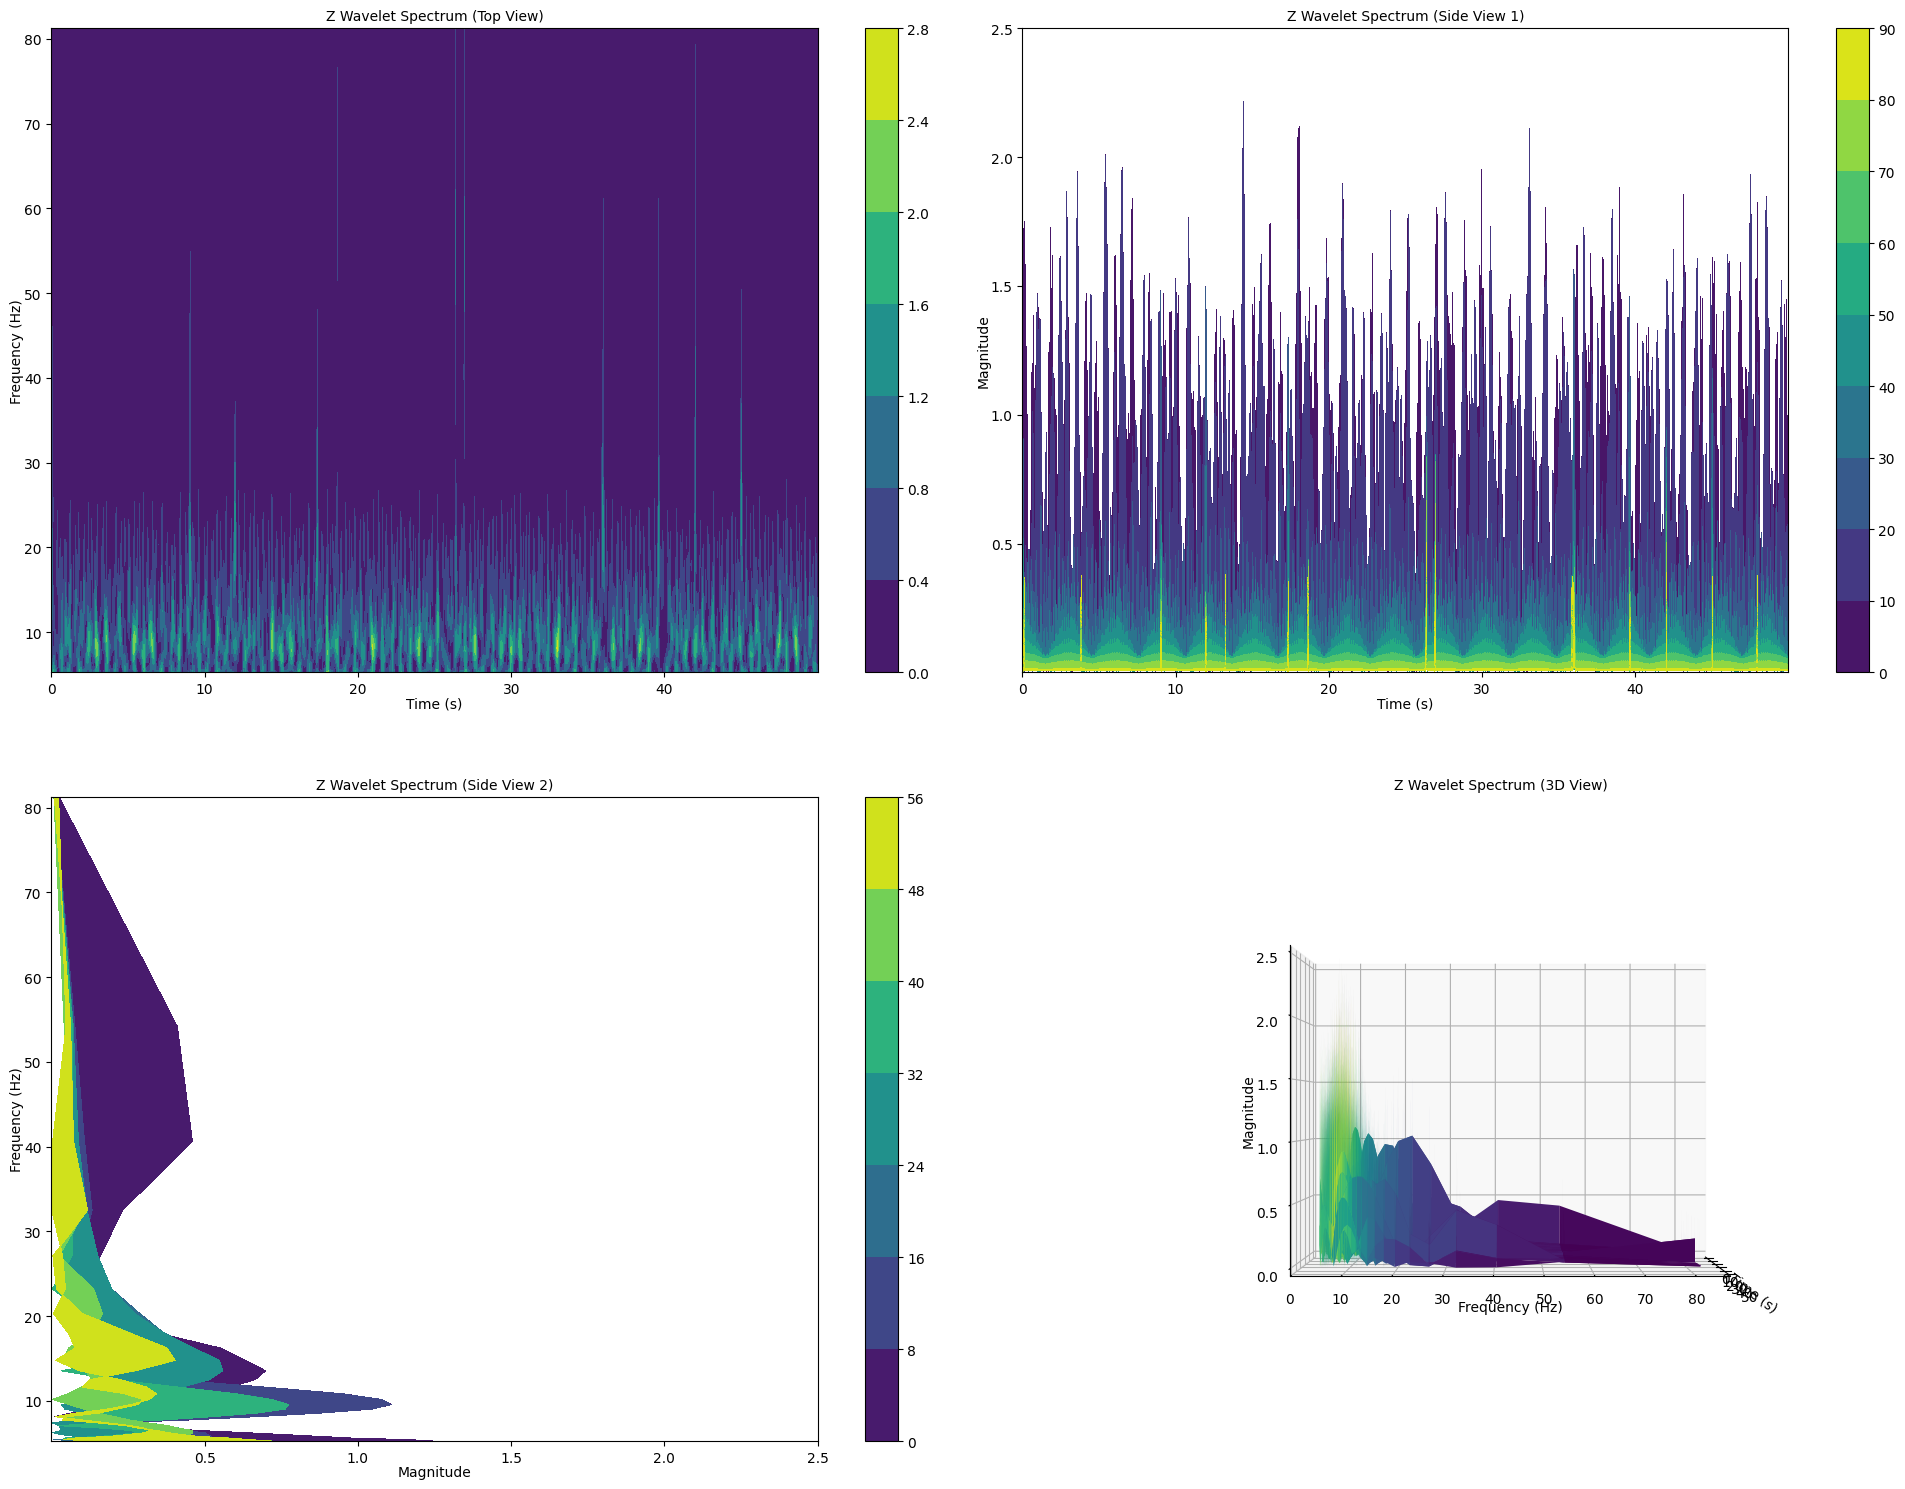

In [21]:
plot.wavelet_spectrum_views(df, spectrum, frequencies, label)

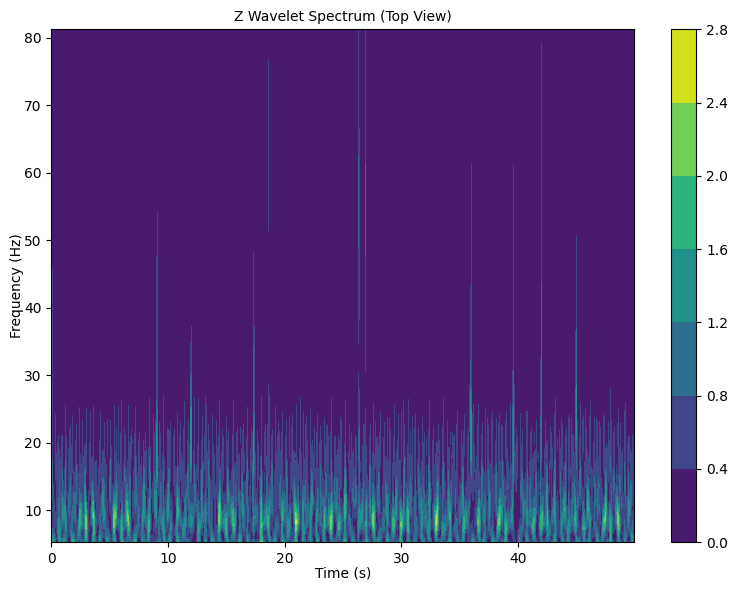

In [22]:
plot.wavelet_spectrum_time_frequency(df, spectrum, frequencies, label)

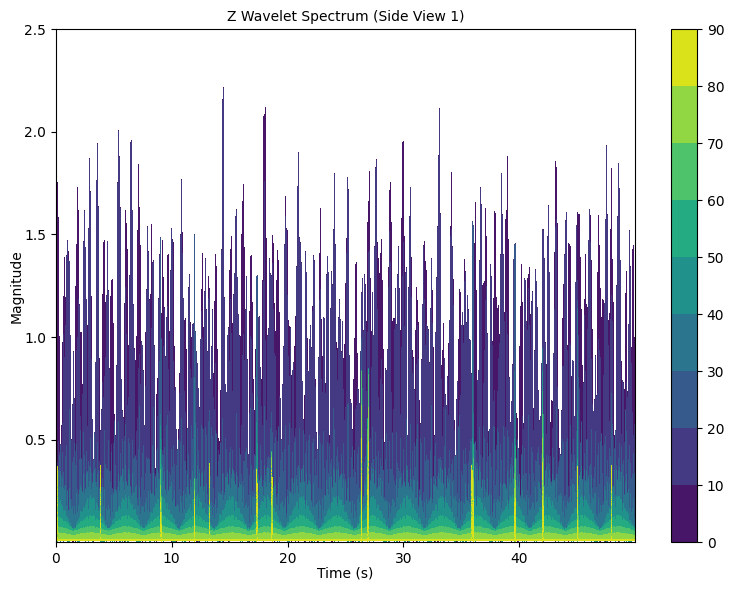

In [23]:
plot.wavelet_spectrum_time_magnitude(df, spectrum, frequencies, label)

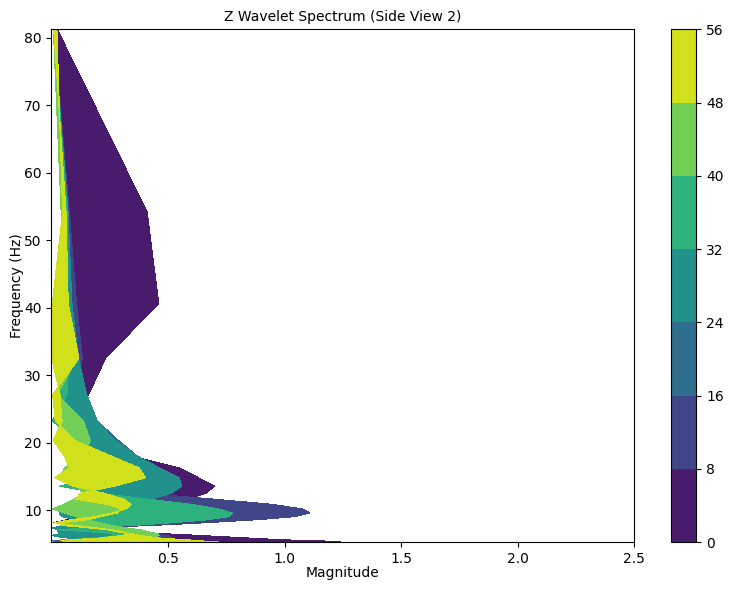

In [24]:
plot.wavelet_spectrum_frequency_magnitude(
    df,
    spectrum,
    frequencies,
    label
)

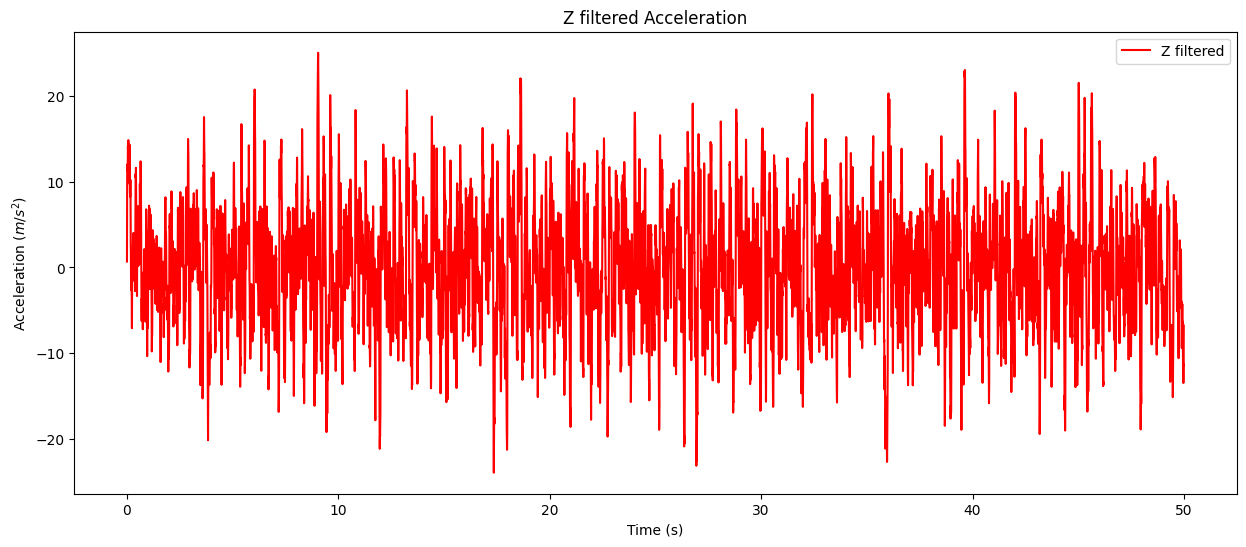

In [25]:
plot.acceleration(df, label_filtered)

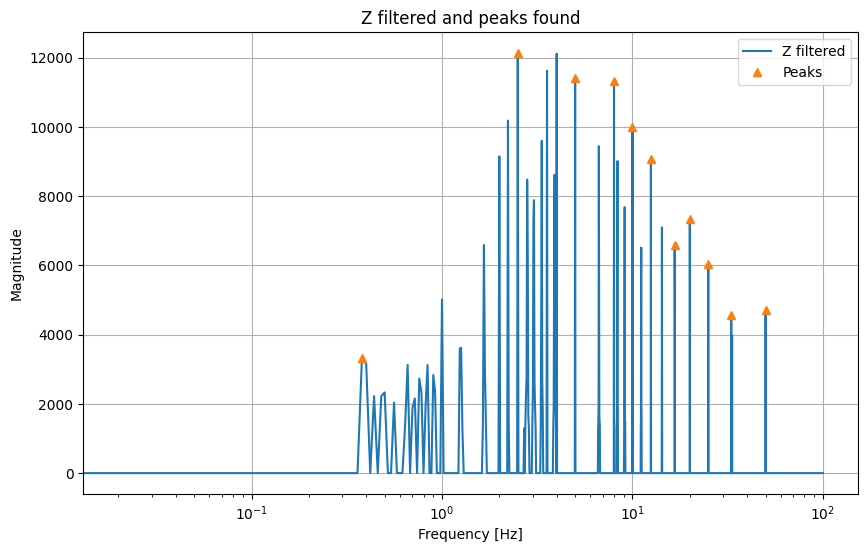

In [41]:
max_magnitude = max(df_fft[f'{label_filtered} Magnitude'])
height = 1000
max_frequency = max(df_fft['Frequency'])
distance = 100
plot.peaks(df_fft, label_filtered, height=height, distance=distance, log_scale = True)

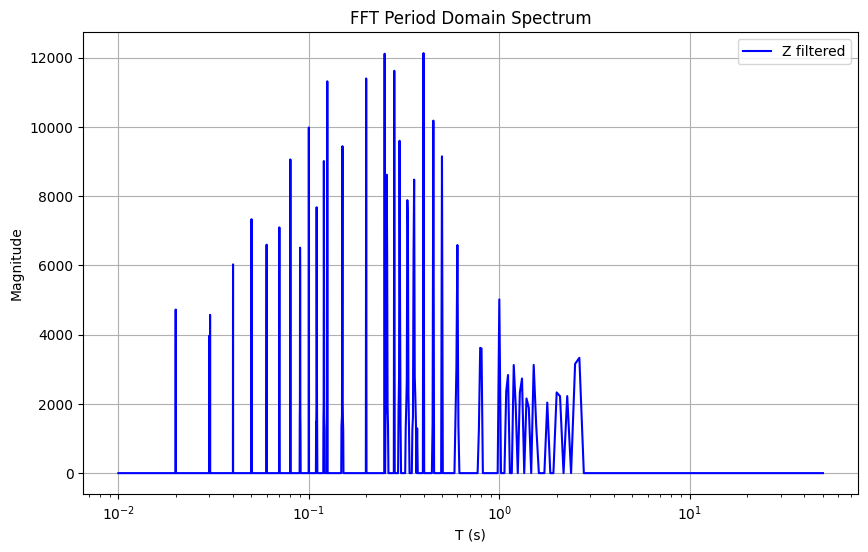

In [29]:
plot.fft_results_period_domain(df_fft, label_filtered, color='blue', log_scale=True)

In [32]:
df_ssicov = analysis.ssi_analysis(df, label_filtered, Ts=20, Nmin=2, Nmax=32, threshold=1000)

In [33]:
df_ssicov

,Frequency,Power Spectrum Z filtered,Natural Frequencies,Damping Ratios,Number of Poles
0,0.00,0.0000,0.071889,-0.899709,0.0
1,0.02,0.0004,0.071889,-0.899709,10.0
2,0.04,0.0016,0.022682,-0.989862,10.0
3,0.06,0.0036,0.022682,-0.989862,10.0
4,0.08,0.0064,0.013065,-0.996633,10.0
...,...,...,...,...,...
4995,99.90,9980.0100,NaN,NaN,10.0
4996,99.92,9984.0064,NaN,NaN,10.0
4997,99.94,9988.0036,NaN,NaN,10.0
4998,99.96,9992.0016,NaN,NaN,10.0


In [34]:

def plot_ssicov_results(df, label, stability_data=None):
    """
    Plots the SSCOV results and optionally the stability diagram.

    Args:
        frequencies (array-like): Frequencies corresponding to the power spectrum.
        power_spectrum (array-like): Power spectrum values.
        label (str): Data label (e.g., 'X').
        stability_data (tuple, optional): Tuple containing (frequencies_stab, num_poles). If None, stability plot is skipped.
    """
    frequencies = df['Frequency']
    power_spectrum = df[f'Power Spectrum {label}']
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(frequencies, power_spectrum, label=f"Power Spectrum {label}", color='tab:blue')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Power', color='tab:blue')
    ax1.tick_params('y', labelcolor='tab:blue')
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Plot stability diagram on a second y-axis
    if stability_data:
        try:
            frequencies_stab, num_poles = stability_data
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.plot(frequencies_stab, num_poles, marker='o', linestyle='-', color='tab:orange', label='Number of Poles')
            ax2.set_ylabel('Number of Poles', color='tab:orange')  # we already handled the x-label with ax1
            ax2.tick_params(axis='y', labelcolor='tab:orange')
            ax2.legend(loc='upper right')  # Add legend for the second y-axis

            # Check that both axes are covered
            fig.tight_layout()
            plt.title(f'Power Spectrum and Stability Diagram ({label})')
        except ValueError as ve:
            print(f"ValueError plotting stability data: {ve}. Skipping stability plot.")
        except Exception as e:
            print(f"Error plotting stability data: {e}. Skipping stability plot.")
    else:
        plt.title(f'Power Spectrum ({label})')

    plt.show()

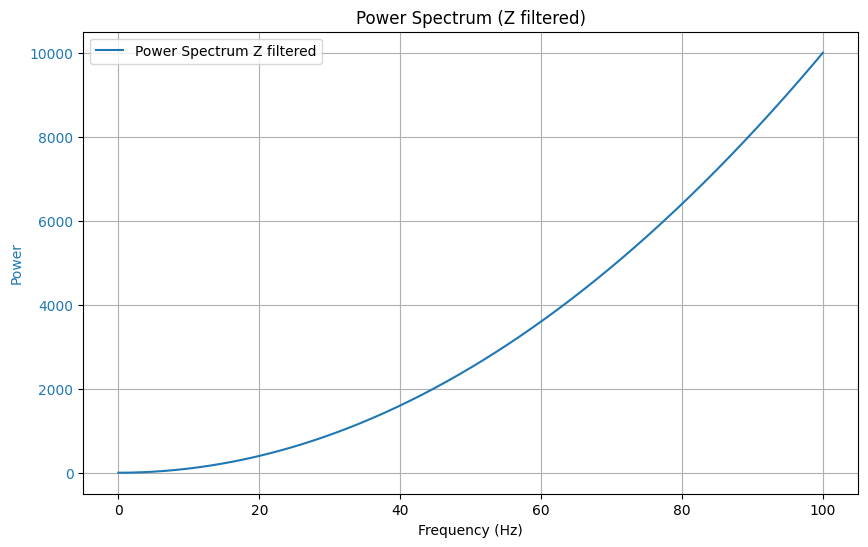

In [36]:
plot.ssicov_results(df_ssicov, label_filtered)